# <center> Shape analysis of cancer cells </center>

In this notebook, we study *Osteosarcoma* (bone cancer) cells and the impact of drug treatment on their *morphological shapes*, by analyzing cell images obtained from fluorescence microscopy. 

This analysis relies on the *elastic metric between discrete curves* that is implemented on Geomstats. We will study to which extent this metric can detect how the cell shape is associated with the response to treatment.

<td>
    <img src='cells_image.png'>
</td>

Figure 1: Representative images of the cell lines using fluorescence microscopy, studied in this notebook (Image credit : Ashok Prasad). The cells nuclei (blue), the actin cytoskeleton (green) and the lipid membrane (red) of each cell are stained and colored. We only focus on the cell shape in our analysis.

# 1. Introduction and motivation

Biological cells adopt a variety of shapes, determined by multiple processes and biophysical forces under the control of the cell. These shapes can be studied with different quantitative measures that reflect the cellular morphology (MGCKCKDDRTWSBCC2018). With the emergence of large-scale biological cell image data, morphological studies have many applications. For example, measures of irregularity and spreading of cells allow accurate classification and discrimination between cancer cell lines treated with different drugs (AXCFP2019).

As a metric defined on the shape space of curves, the *elastic metric* (SKJJ2010), which is implemented in Geomstats, is another potential tool for analyzing and comparing biological cell shapes. While its associated geodesics and geodesic distances provide a natural framework for optimally matching, deforming, and comparing shapes, this metric, to our knowledge, has not been applied so far to analyze biological cells. 

**References**

(MGCKCKDDRTWSBCC2018) McQuin C, Goodman A, Chernyshev V, Kamentsky L, Cimini BA, Karhohs KW, Doan M, Ding L, Rafelski SM, Thirstrup D, Wiegraebe W, Singh S, Becker T, Caicedo JC, Carpenter AE (2018). CellProfiler 3.0: Next-generation image processing for biology. PLoS Biol. 16(7):e2005970 / doi. PMID: 29969450

(AXCFP2019) Alizadeh E, Xu W, Castle J, Foss J, Prasad A. TISMorph: A tool to quantify texture, irregularity and spreading of single cells. PloS one. 2019 Jun 3;14(6):e0217346.

(SKJJ2010) Srivastava A, Klassen E, Joshi SH, Jermyn IH. Shape analysis of elastic curves in euclidean spaces. IEEE Transactions on Pattern Analysis and Machine Intelligence. 2010 Oct 14;33(7):1415-28.

# 2. Analysis

### Setup

In [1]:
import sys
!{sys.executable} -m pip install git+https://github.com/geomstats/geomstats.git
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scikit-learn

  Cloning https://github.com/geomstats/geomstats.git to /tmp/pip-req-build-bdu59r7i
  Running command git clone -q https://github.com/geomstats/geomstats.git /tmp/pip-req-build-bdu59r7i
  Created wheel for geomstats: filename=geomstats-2.5.0-py3-none-any.whl size=7544710 sha256=4216e4df681dac242ac6c05f5e60012822a52b3f5b23ccabc0c78179016d61f4
  Stored in directory: /tmp/pip-ephem-wheel-cache-ef8mhxkr/wheels/c1/18/96/0637d829ebefc4aa9e57006845538aa54f6c0e9619e6b56541
Successfully built geomstats


In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
import matplotlib
import matplotlib.pyplot as plt

import geomstats.backend as gs

gs.random.seed(2021)

INFO: Using numpy backend


## 2.1. Dataset description

We study a dataset of mouse *Osteosarcoma* imaged cells (AXCFP2019). The dataset contains two different cancer cell lines : *DLM8* and *DUNN*.  Among these cells, some have also been treated with different single drugs that perturb the cellular cytoskeleton. Overall, we can label each cell according to their cell line (*DLM8* and *DUNN*), and also if it is a *control* cell (no treatment), or has been treated with one of the following drugs : *Jasp* (jasplakinolide) and *Cytd* (cytochalasin D).

**Reference**

(AXCFP2019) Alizadeh E, Xu W, Castle J, Foss J, Prasad A. TISMorph: A tool to quantify texture, irregularity and spreading of single cells. PloS one. 2019 Jun 3;14(6):e0217346.

Each cell comes from a raw image containing a bunch of cells, which was thresholded to generate binarized images, as illustrated here:

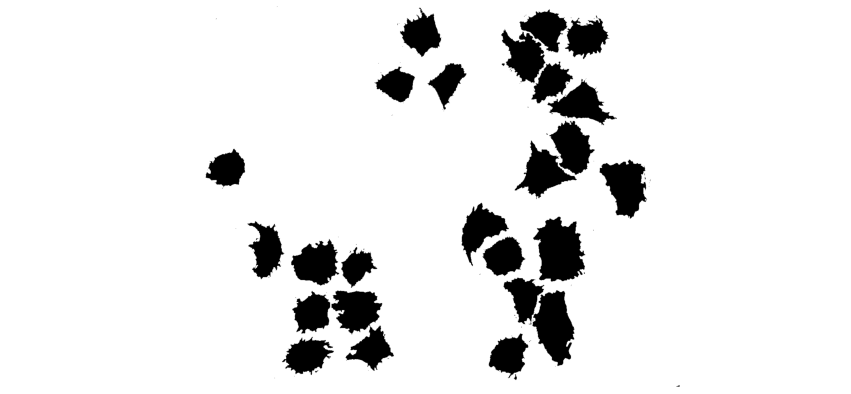

In [4]:
import cv2

img = cv2.imread('binary_image.tif')
plt.figure(figsize=(15, 7))
plt.axis('equal')
plt.axis('off')
plt.imshow(img)

Figure 2: Binarised image of cells

After binarizing the images, contouring was used to isolate each cell, and extract their boundaries as a counter-clockwise ordered list of 2D coordinates, which corresponds to the representation of discrete curve in Geomstats. We load these discrete curves into the notebook:

In [5]:
def load_cells():
    """Load cell data.

    Returns
    -------
    cells : list of 2D discrete curves
        Each curve represents the boundary of a cell, their lengths
        are not necessarily equal.
    cell_lines : array of strings
        List of the cell lines of each cell.
    treatments : array of strings
        List of the treatments given to each cell.
    """
    with open("cells.txt") as cells_file:
        cells = cells_file.read().split('\n\n')
    for i, cell in enumerate(cells):
        cell = cell.split('\n')
        curve = []
        for point in cell:
            coords = [int(coord) for coord in point.split()]
            curve.append(coords)
        cells[i] = gs.array(curve)
    with open("cell_lines.txt") as cell_lines_file:
        cell_lines = gs.array(cell_lines_file.read().split('\n'))
    with open("treatments.txt") as treatments_file:
        treatments = gs.array(treatments_file.read().split('\n'))
    return cells, cell_lines, treatments

In [6]:
cells, cell_lines, treatments = load_cells()
print(f'Total number of cells : {len(cells)}')

Total number of cells : 650


The cells are grouped by class in the dataset : the *control* cells, the cells treated with *Cytd* and finally the ones treated with *Jasp*. Also, in each of these classes, there are two cell lines : the *DLM8* cells and the *DUNN* ones.

The size of each class is displayed below:

In [7]:
for treatment in ["control", "cytd", "jasp"]:
    nb_dlm8 = gs.sum((treatments == treatment) & (cell_lines == "dlm8"))
    nb_dunn = gs.sum((treatments == treatment) & (cell_lines == "dunn"))
    print(f'{treatment} : {nb_dlm8} DLM8 and {nb_dunn} DUNN')

control : 114 DLM8 and 204 DUNN
cytd : 82 DLM8 and 93 DUNN
jasp : 62 DLM8 and 95 DUNN


## 2.2 Preprocessing Data

### Encoding discrete curves with same number of points

As we need discrete curves with the same number of sampled points to compute pairwise distances, the following interpolation is applied to each curve, after setting the number of sampling points.

To set up the number of sampling points, you can edit the following line in the next cell:

In [8]:
def interpolate(curve, nb_points):
    """Interpolate a discrete curve with nb_points from a discrete curve.

    Returns
    -------
    interpolation : discrete curve with nb_points points
    """
    old_length = curve.shape[0]
    interpolation = gs.zeros((nb_points, 2))
    incr = old_length/nb_points
    pos = 0
    for i in range(nb_points):
        index = int(gs.floor(pos))
        interpolation[i] = curve[index] + (pos - index)*(curve[(index + 1)%old_length] - curve[index])
        pos += incr
    return interpolation

nb_sampling = 100

To illustrate the result of this interpolation, we compare for a randomly chosen cell the original curve with the correponding interpolated one (to visualize another cell, you can simply re-run the code).

(1116.375, 1229.125, -283.2620000000003, -199.178)

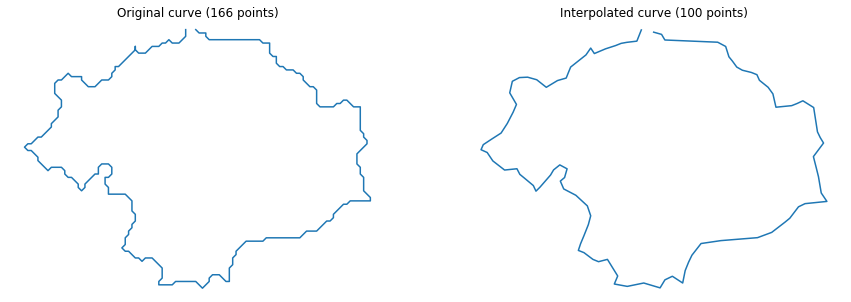

In [9]:
i = gs.random.randint(len(cells))
cell = cells[i]
cell_interpolation = interpolate(cells[i], nb_sampling)

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plt.plot(cell[:, 0], cell[:, 1])
plt.axis('equal')
plt.title(f"Original curve ({len(cell)} points)")
plt.axis('off')

fig.add_subplot(122)
plt.plot(cell_interpolation[:, 0], cell_interpolation[:, 1])
plt.axis('equal')
plt.title(f"Interpolated curve ({nb_sampling} points)")
plt.axis('off')

In [10]:
for i in range(len(cells)):
    cells[i] = interpolate(cells[i], nb_sampling)

For a sample of control cells and a sample of treated cells, we hence obtained the following sets of curves (top row shows control, i.e. non-treated cells; bottom row shows treated cells):

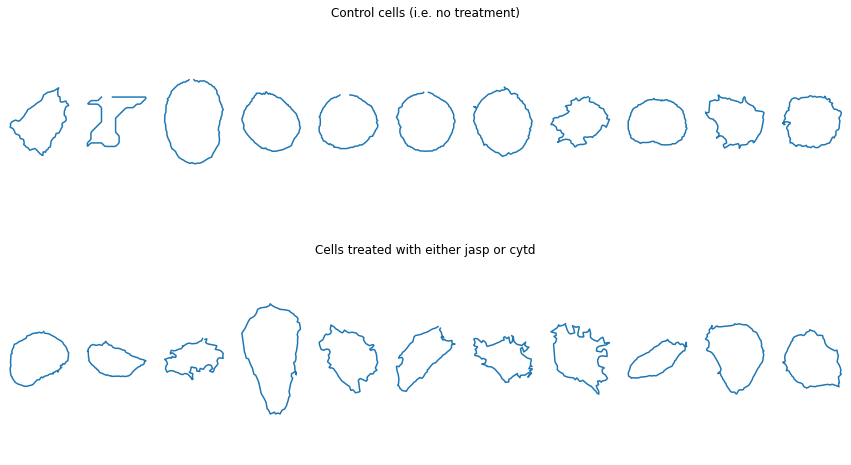

In [11]:
nb_cells = 11

control_i = gs.random.randint(0, 300, size=nb_cells)
jasp_i = gs.random.randint(500, 600, size=nb_cells)

fig = plt.figure(figsize=(15, 8))

for i in range(nb_cells):
    cell = cells[control_i[i]]
    fig.add_subplot(2, nb_cells, i + 1)
    plt.plot(cell[:, 0], cell[:, 1])
    if i == nb_cells//2:
        plt.title("Control cells (i.e. no treatment)")
    plt.axis('equal')
    plt.axis('off')
    
for i in range(nb_cells):
    cell = cells[jasp_i[i]]
    fig.add_subplot(2, nb_cells, i + nb_cells + 1)
    plt.plot(cell[:, 0], cell[:, 1])
    if i == nb_cells//2:
        plt.title("Cells treated with either jasp or cytd")
    plt.axis('equal')
    plt.axis('off')

Visual inspection of these curves seems to indicate more protusions appearing in treated cells, compared with control ones. This is in agreement with the physiological impact of the drugs, which are known to perturb the internal cytoskeleton connected to the cell membrane. Using the elastic metric, our goal will be to see if we can quantitatively confirm these differences.

### Alignment and re-parametrization

Our goal is to study the cell boundaries in our dataset, as points in a shape space of closed curves quotiented by translation, scaling, and rotation, so these transformations do not affect our measure of distance between curves.

In practice, we apply functions that were initially designed to center (substract the barycenter), rescale (divide by the Frobenius norm) and then align (find the rotation minimizing the L² distance) two sets of landmarks. Since we are working with closed curves, the starting point associated with the parametrization of the discrete curves is also arbitrary. Thus, we conduct an exhaustive search to find which parametrization produces the best alignment according to the above procedure (i.e. the distance to the base curve is the smallest). 

After running this protocol to align all the curves of the dataset against the first one (cf. next two blocks), our set of curves is now processed and ready for the analysis.

In [12]:
from geomstats.geometry.pre_shape import PreShapeSpace, KendallShapeMetric
import numpy as np

m_ambient = 2
k_landmarks = nb_sampling

preshape = PreShapeSpace(m_ambient=m_ambient, k_landmarks=k_landmarks)
matrices_metric = preshape.embedding_metric

cells_preshape = preshape.projection(cells)

base_curve = cells_preshape[0]

def exhaustive_align(curve, base_curve):
    """Align curve to base_curve to minimize the L² distance.

    Returns
    -------
    aligned_curve : discrete curve
    """
    nb_sampling = len(curve)
    distances = gs.zeros(nb_sampling)
    for shift in range(nb_sampling):
        reparametrized = [curve[(i + shift)%nb_sampling] for i in range(nb_sampling)]
        aligned = preshape.align(point=gs.array(reparametrized), base_point=gs.array(base_curve))
        distances[shift] = matrices_metric.norm(gs.array(aligned) - gs.array(base_curve))
    shift_min = gs.argmin(distances)
    reparametrized_min = [curve[(i + shift_min)%nb_sampling] for i in range(nb_sampling)]
    aligned_curve = preshape.align(point=gs.array(reparametrized_min),base_point=gs.array(base_curve))
    return aligned_curve

cells_shape = [exhaustive_align(np.array(curve), np.array(base_curve)) for curve in np.array(cells_preshape)]

Text(0.5, 1.0, 'Aligned curve')

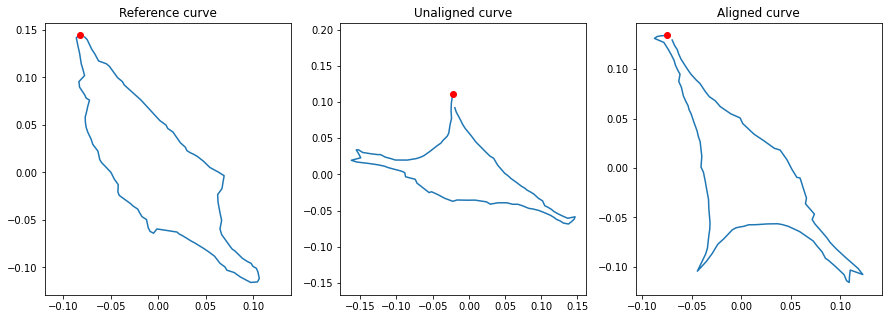

In [13]:
i = gs.random.randint(len(cells_shape))

base_cell = cells_preshape[0]
unaligned_cell = cells_preshape[i]
aligned_cell = cells_shape[i]

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
plt.plot(base_cell[:, 0], base_cell[:, 1])
plt.plot(base_cell[0, 0], base_cell[0, 1], 'ro')
plt.axis('equal')
plt.title("Reference curve")

fig.add_subplot(132)
plt.plot(unaligned_cell[:, 0], unaligned_cell[:, 1])
plt.plot(unaligned_cell[0, 0], unaligned_cell[0, 1], 'ro')
plt.axis('equal')
plt.title("Unaligned curve")

fig.add_subplot(133)
plt.plot(aligned_cell[:, 0], aligned_cell[:, 1])
plt.plot(aligned_cell[0, 0], aligned_cell[0, 1], 'ro')
plt.axis('equal')
plt.title("Aligned curve")

In the plot above, the red dot shows the start of the parametrization of each curve. The right curve has been rotated from the curve in the middle, to be aligned with the left (reference) curve, which represents the first cell of the dataset. The starting point (in red) of this right curve has been also set to align with the reference.

## 2.3 Data analysis

### 2.3.A Geodesic trajectory joining two cell shapes

Using *Geomstats*, we can compute geodesics between discrete curves with respect to the elastic metric (SKJJ2010). In our data, these geodesics represent trajectories between cell boundaries that minimize an elastic energy, and the length of the geodesic defines a distance between curves. We illustrate such a geodesic between two cells (run the block again to get a trajectory joining two other randomly chosen cells):

**Reference**

(SKJJ2010) Srivastava A, Klassen E, Joshi SH, Jermyn IH. Shape analysis of elastic curves in euclidean spaces. IEEE Transactions on Pattern Analysis and Machine Intelligence. 2010 Oct 14;33(7):1415-28.

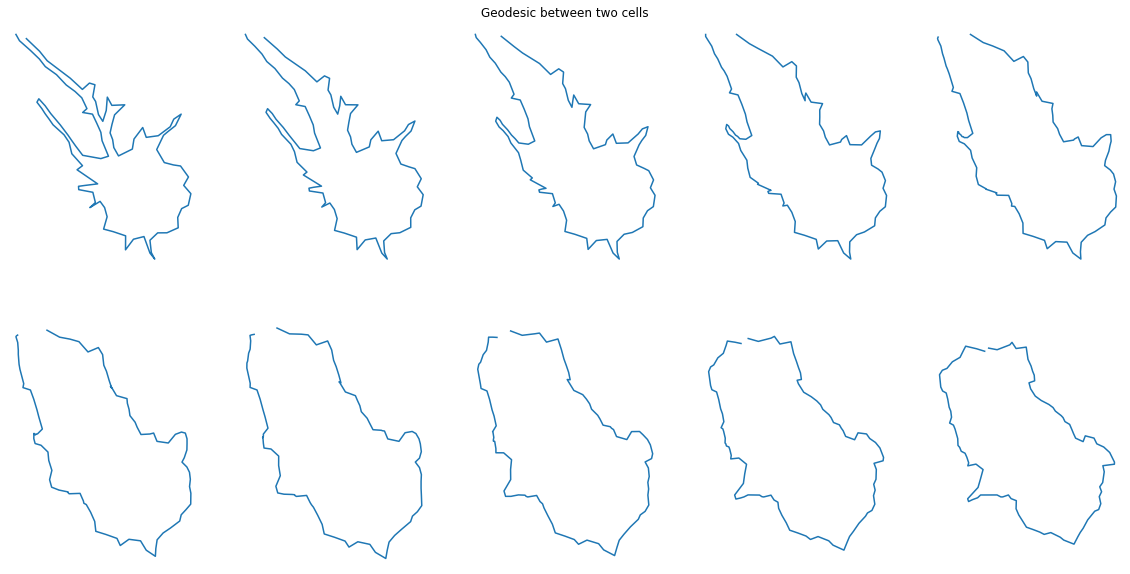

In [14]:
from geomstats.geometry.discrete_curves import R2, DiscreteCurves, SRVMetric

curves = DiscreteCurves(R2)
metric = curves.srv_metric

i, j = gs.random.randint(len(cells_shape), size=2)

geodesic = metric.geodesic(initial_curve=cells_shape[i], end_curve=cells_shape[j])

points = geodesic(gs.linspace(0., 1., 10))

fig = plt.figure(figsize = (20, 10))
plt.title("Geodesic between two cells")
plt.axis('off')

for i, curve in enumerate(points):
    fig.add_subplot(2, int(len(points)/2), i + 1)
    plt.plot(curve[:, 0], curve[:, 1])
    plt.axis('equal')
    plt.axis('off')

### 2.3.B Whole dataset study


The distance can be evaluated by computing the L² distances between the square root velocities of the curves (SKJJ2010). By computing these in our dataset, we obtain the distance matrix of the dataset with respect to the elastic metric, as follows:  

*Remark 1:* Note that to use these square root velocities properly, we need to quotient out the curves by rigid body transformations, which was done during the pre-processing.

*Remark 2:* We did not use the ```dist``` function from Geomstats because it is computationally expensive (repeatedly computing the same square root velocities). Besides, this implementaion also includes the distance between the two starting points in the metric, which is not relevant in our case.

**Reference**

(SKJJ2010) Srivastava A, Klassen E, Joshi SH, Jermyn IH. Shape analysis of elastic curves in euclidean spaces. IEEE Transactions on Pattern Analysis and Machine Intelligence. 2010 Oct 14;33(7):1415-28.

In [16]:
N = len(cells_shape)
# srvs = [metric.square_root_velocity(cell) for cell in cells_shape]
dist_matrix = gs.zeros((N, N))

for i in range(N):
    for j in range(i, N):
        # dist = curves.l2_metric(nb_sampling - 1).dist(cells_shape[i], cells_shape[j])
        try:
            dist = curves.srv_metric.dist(cells_shape[i], cells_shape[j])
            dist_matrix[i, j] = dist_matrix[j, i] = dist
        except Exception as e:
            print("i:", i, "j:", j)

i: 0 j: 151
i: 1 j: 151
i: 2 j: 151
i: 3 j: 151
i: 4 j: 151
i: 5 j: 151
i: 6 j: 151
i: 7 j: 151
i: 8 j: 151
i: 9 j: 151
i: 10 j: 151
i: 11 j: 151
i: 12 j: 151
i: 13 j: 151
i: 14 j: 151
i: 15 j: 151
i: 16 j: 151
i: 17 j: 151
i: 18 j: 151
i: 19 j: 151
i: 20 j: 151
i: 21 j: 151
i: 22 j: 151
i: 23 j: 151
i: 24 j: 151
i: 25 j: 151
i: 26 j: 151
i: 27 j: 151
i: 28 j: 151
i: 29 j: 151
i: 30 j: 151
i: 31 j: 151
i: 32 j: 151
i: 33 j: 151
i: 34 j: 151
i: 35 j: 151
i: 36 j: 151
i: 37 j: 151
i: 38 j: 151
i: 39 j: 151
i: 40 j: 151
i: 41 j: 151
i: 42 j: 151
i: 43 j: 151
i: 44 j: 151
i: 45 j: 151
i: 46 j: 151
i: 47 j: 151
i: 48 j: 151
i: 49 j: 151
i: 50 j: 151
i: 51 j: 151
i: 52 j: 151
i: 53 j: 151
i: 54 j: 151
i: 55 j: 151
i: 56 j: 151
i: 57 j: 151
i: 58 j: 151
i: 59 j: 151
i: 60 j: 151
i: 61 j: 151
i: 62 j: 151
i: 63 j: 151
i: 64 j: 151
i: 65 j: 151
i: 66 j: 151
i: 67 j: 151
i: 68 j: 151
i: 69 j: 151
i: 70 j: 151
i: 71 j: 151
i: 72 j: 151
i: 73 j: 151
i: 74 j: 151
i: 75 j: 151
i: 76 j: 151
i: 77 j: 

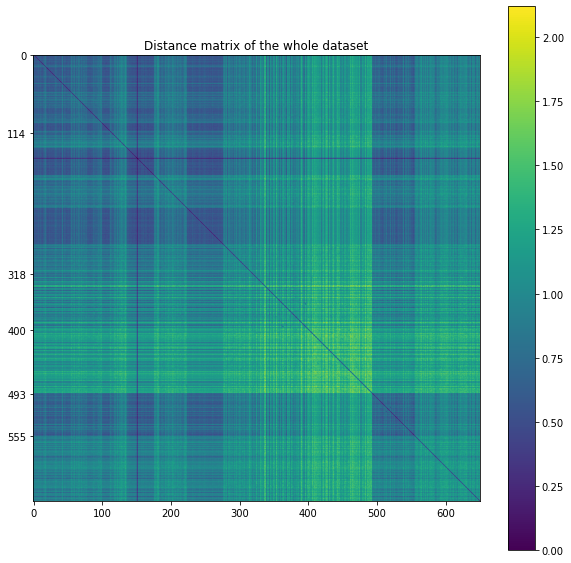

In [17]:
plt.figure(figsize=(10, 10))
plt.title("Distance matrix of the whole dataset")
plt.imshow(dist_matrix)
ticks = [0, 114, 318, 400, 493, 555]
plt.yticks(ticks)
plt.colorbar()

We ordered the cells in the above distance matrix according to their label, as follows:

0-113: *Control DLM8* 

114-317: *Control DUNN*

318-399: *Cytd treated DLM8*

400-492: *Cytd treated DUNN*

493-554: *Jasp treated DLM8*

555-649: *Jasp treated DUNN*


A visual inspection of the distance matrix shows the presence of sub-blocks within each class, which contain closer cells and are are also more or less close to each other. Since the cells were obtained from imaging cell populations on a shared plate, this can be partly due to shared conditions at the time of the experiment - see also (LAM2016)-.

Upon considering each group (according to the labeling described above), we also observe more similarity within  Control (DLM8 and DUNN) cells, and DLM8 jasp treated cells. Some blocks of the same class show more dissimlarity, e.g. DUNN cytd treated cells.<br>

Overall, the dataset structure revealed by the elastic metric is quite complex, with some patterns that we need to analyze further.

**Reference**

(LAM2016) Lyons SM, Alizadeh E, Mannheimer J, et al. Changes in cell shape are correlated with metastatic potential in murine and human osteosarcomas. Biol Open. 2016;5(3):289-299. Published 2016 Feb 12. doi:10.1242/bio.013409

### Multidimensional scaling

To better visualize our results, we apply 2D multidimensional scaling, which is a dimension reduction method that project the data in 2D space, while trying to preserve the distances between data points. First, we apply it to the whole dataset to see whether treatments, or cell lines, can be separated.

In [18]:
from sklearn import manifold
import numpy as np

mds = manifold.MDS(n_components=2, random_state = 1, dissimilarity="precomputed")
pos = mds.fit(dist_matrix).embedding_

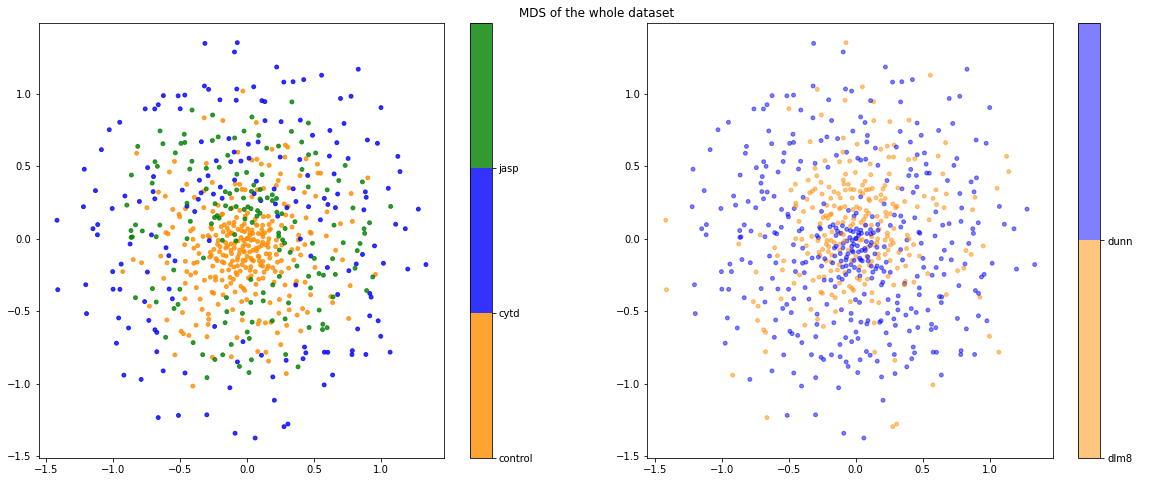

In [19]:
cell_lines_strings, cell_lines_labels = np.unique(cell_lines, return_inverse=True)
treatments_strings, treatments_labels = np.unique(treatments, return_inverse=True)

fig = plt.figure(figsize=(20, 8))
plt.title("MDS of the whole dataset")
plt.axis('off')

fig.add_subplot(121)
colors = ["darkorange", "blue", "green"]
plt.scatter(pos[:, 0], pos[:, 1], c=treatments_labels, 
            cmap=matplotlib.colors.ListedColormap(colors), alpha=0.8, s=15)
cb = plt.colorbar()
loc = np.arange(0,max(treatments_labels),max(treatments_labels)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([treatments_strings[0], treatments_strings[1], treatments_strings[2]])

fig.add_subplot(122)
colors = ["darkorange", "blue"]
plt.scatter(pos[:, 0], pos[:, 1], c=cell_lines_labels, 
            cmap=matplotlib.colors.ListedColormap(colors), alpha=0.5, s=15)
cb = plt.colorbar()
loc = np.arange(0,max(cell_lines_labels),max(cell_lines_labels)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([cell_lines_strings[0], cell_lines_strings[1]])

In left, we compare Control (non-treated), *Jasp* and *Cytd* treated cells. Most of the control cells (in orange) are more concentrated in the center, with some variability that spreads some points at the periphery. As expected from the distance matrix, *Cytd* treated cells are widely spread out and far from most of the other cells. Finally, *Jasp* treated cells are also quite spread, but less than the *Cytd* ones, and closer to *control* cells.

In right, we compare the two cell lines DUNN and DLM8. While DLM8 cells seem to show less variability, DUNN cells seem to indicate two behaviors: a concentration at the center, and higher variability for the rest (which could be due to difference in *control* vs treatment, as studied in more details below). 

#### Comparison of Control and treatments

We now focus on one particular cell line at a time, to investigate the effects of the drugs on the cell shapes. Applying the MDS again gives the following results:

In [20]:
dlm8_control_indexes = gs.where((cell_lines == "dlm8") & (treatments == "control"))[0]
dlm8_cytd_indexes = gs.where((cell_lines == "dlm8") & (treatments == "cytd"))[0]
dlm8_jasp_indexes = gs.where((cell_lines == "dlm8") & (treatments == "jasp"))[0]

dlm8_indexes = gs.concatenate((dlm8_jasp_indexes, dlm8_cytd_indexes, dlm8_control_indexes))
dlm8_matrix = dist_matrix[dlm8_indexes][:, dlm8_indexes]

dlm8_mds = manifold.MDS(n_components=2, random_state = 1, dissimilarity="precomputed")
dlm8_pos = dlm8_mds.fit(dlm8_matrix).embedding_

dunn_control_indexes = gs.where((cell_lines == "dunn") & (treatments == "control"))[0]
dunn_cytd_indexes = gs.where((cell_lines == "dunn") & (treatments == "cytd"))[0]
dunn_jasp_indexes = gs.where((cell_lines == "dunn") & (treatments == "jasp"))[0]

dunn_indexes = gs.concatenate((dunn_control_indexes, dunn_cytd_indexes, dunn_jasp_indexes))
dunn_matrix = dist_matrix[dunn_indexes][:, dunn_indexes]

dunn_mds = manifold.MDS(n_components=2, random_state = 1, dissimilarity="precomputed")
dunn_pos = dunn_mds.fit(dunn_matrix).embedding_

dunn_control_matrix = dist_matrix[dunn_control_indexes][:, dunn_control_indexes]

In [24]:
# save dunn_control_matrix
np.savetxt("../datasets/dunn_control_matrix.txt", dunn_control_matrix)
np.savetxt("../datasets/dunn_control_indexes.txt", dunn_control_indexes, fmt="%d")

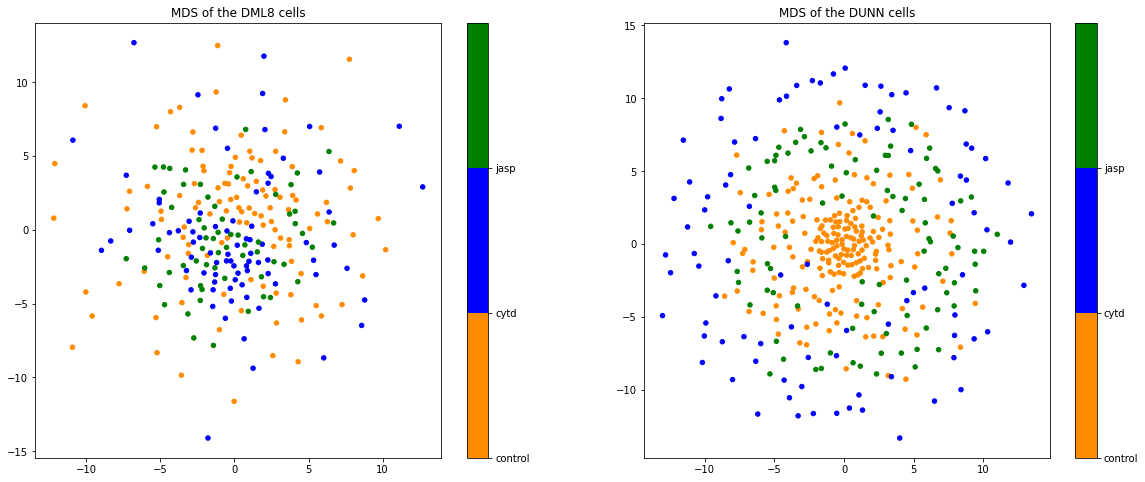

In [76]:
,dlm8_treatments = treatments[cell_lines == "dlm8"]
dlm8_treatments_strings, dlm8_treatments_labels = np.unique(dlm8_treatments, return_inverse=True)

dunn_treatments = treatments[cell_lines == "dunn"]
dunn_treatments_strings, dunn_treatments_labels = np.unique(dunn_treatments, return_inverse=True)

colors = ["darkorange", "blue", "green"]

fig = plt.figure(figsize=(20, 8))

fig.add_subplot(121)
plt.title("MDS of the DML8 cells")
plt.scatter(dlm8_pos[:, 0], dlm8_pos[:, 1], c=dlm8_treatments_labels, 
            cmap=matplotlib.colors.ListedColormap(colors), s=20)
cb = plt.colorbar()
loc = np.arange(0,max(dlm8_treatments_labels),max(dlm8_treatments_labels)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([dlm8_treatments_strings[0], dlm8_treatments_strings[1], dlm8_treatments_strings[2]])

fig.add_subplot(122)
plt.title("MDS of the DUNN cells")
plt.scatter(dunn_pos[:, 0], dunn_pos[:, 1], c=dunn_treatments_labels, 
            cmap=matplotlib.colors.ListedColormap(colors), s=20)
cb = plt.colorbar()
loc = np.arange(0,max(dunn_treatments_labels),max(dunn_treatments_labels)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([dunn_treatments_strings[0], dunn_treatments_strings[1], dunn_treatments_strings[2]])

In left, the MDS applied to *DLM8* cells does not seem to produce any clear separation or pattern across the three treatment classes. 

In contrast, the MDS applied to *DUNN* cells, in right, yields a stacked group of *control* cells in the center, which could mean that *DUNN* cells are more affected by the treatments than the *DLM8* ones. Furthermore, for *DUNN* cells, the *Cytd* treatment seems to create more significant variability in shape variability than the *Jasp* treatment. 

#### Comparison of cell lines for each treatment

We now consider each treatment class separately, and study as previously the shape differences between the two cell lines:

In [77]:
control_indexes = gs.concatenate((dlm8_control_indexes, dunn_control_indexes))
control_matrix = dist_matrix[control_indexes][:, control_indexes]

control_mds = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
control_pos = control_mds.fit(control_matrix).embedding_

cytd_indexes = gs.concatenate((dlm8_cytd_indexes, dunn_cytd_indexes))
cytd_matrix = dist_matrix[cytd_indexes][:, cytd_indexes]

cytd_mds = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
cytd_pos = cytd_mds.fit(cytd_matrix).embedding_

jasp_indexes = gs.concatenate((dlm8_jasp_indexes, dunn_jasp_indexes))
jasp_matrix = dist_matrix[jasp_indexes][:, jasp_indexes]

jasp_mds = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
jasp_pos = jasp_mds.fit(jasp_matrix).embedding_

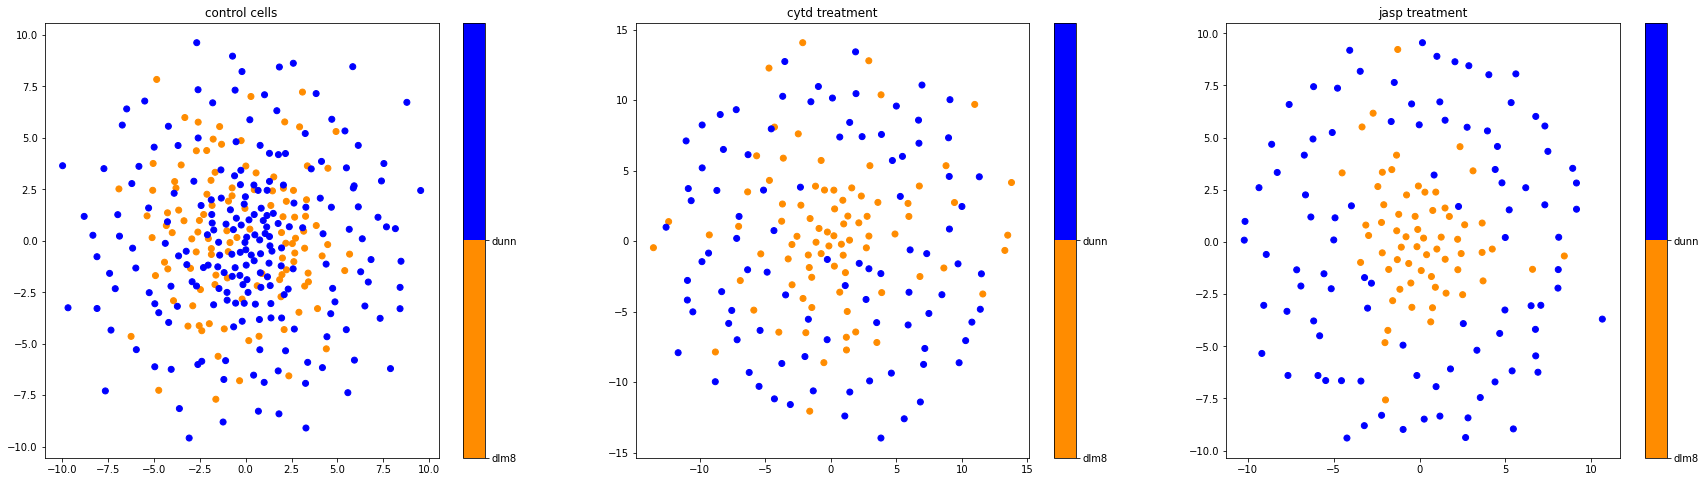

In [78]:
control_cell_lines = cell_lines[treatments == "control"]
control_cell_lines_strings, control_cell_lines_labels = np.unique(control_cell_lines, return_inverse=True)

cytd_cell_lines = cell_lines[treatments == "cytd"]
cytd_cell_lines_strings, cytd_cell_lines_labels = np.unique(cytd_cell_lines, return_inverse=True)

jasp_cell_lines = cell_lines[treatments == "jasp"]
jasp_cell_lines_strings, jasp_cell_lines_labels = np.unique(jasp_cell_lines, return_inverse=True)

colors = ["darkorange", "blue"]

fig = plt.figure(figsize=(30, 8))

fig.add_subplot(131)
plt.title("control cells")
plt.scatter(control_pos[:, 0], control_pos[:, 1], c=control_cell_lines_labels, 
            cmap=matplotlib.colors.ListedColormap(colors))
cb = plt.colorbar()
loc = np.arange(0,max(control_cell_lines_labels),max(control_cell_lines_labels)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([control_cell_lines_strings[0], control_cell_lines_strings[1]])

fig.add_subplot(132)
plt.title("cytd treatment")
plt.scatter(cytd_pos[:, 0], cytd_pos[:, 1], c=cytd_cell_lines_labels, 
            cmap=matplotlib.colors.ListedColormap(colors))
cb = plt.colorbar()
loc = np.arange(0,max(cytd_cell_lines_labels),max(cytd_cell_lines_labels)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([cytd_cell_lines_strings[0], cytd_cell_lines_strings[1]])

fig.add_subplot(133)
plt.title("jasp treatment")
plt.scatter(jasp_pos[:, 0], jasp_pos[:, 1], c=jasp_cell_lines_labels, 
            cmap=matplotlib.colors.ListedColormap(colors))
cb = plt.colorbar()
loc = np.arange(0,max(jasp_cell_lines_labels),max(jasp_cell_lines_labels)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([jasp_cell_lines_strings[0], jasp_cell_lines_strings[1]])

Control cells, on the left, do not seem to produce a clear separation between the two cell lines according to the elastic metric.

For the two treatments however (*cytd* in middle, *jasp* in right), we observe a same pattern of *DLM8* cells being more concentrated and surrounded by *DUNN* cells. This pattern seems more pronounced in *jasp* treated cells. This suggests that the elastic metric can be used as a good feature to distinguish the two cell lines with the same treatment.

*Remark (Biological interpretation):* Most of the results shown here are in line with our biological knowledge of the cell lines and the physiological impact of the drugs. 

### Clustering of the cell lines

From the previous plots, it is natural to try to cluster the MDS of the data within each treatment, to separate the two cell lines. To do so, we first used spectral clustering from scikit-learn, because of the non-linear nature of the data representated, and we compared the accuracy of this spectral clustering for each treatment:

In [79]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import accuracy_score

def spectral_clustering_score(pos, labels):
    """Evaluate the accuracy of spectral clustering on pos.
    
    Returns
    -------
    score : float
    """
    clustering = SpectralClustering(n_clusters=2,
                                    assign_labels='discretize',
                                    random_state=0).fit(pos)
    score = accuracy_score(labels, clustering.labels_)
    return score

print(f'Control score: {spectral_clustering_score(control_pos, control_cell_lines_labels)}')
print(f'Cytd score: {spectral_clustering_score(cytd_pos, cytd_cell_lines_labels)}')
print(f'Jasp score: {spectral_clustering_score(jasp_pos, jasp_cell_lines_labels)}')

Control score: 0.3742138364779874
Cytd score: 0.5142857142857142
Jasp score: 0.6751592356687898


In *control* cells, the accuracy is very bad, as suggested by the previous MDS plot. For the *Cytd* treatment, even if most of the *DLM8* cells are located in the center of the plot, we still cannot distinguish them well from the DUNN cells, which explains the mediocre accuracy. Finally, for the jasp treatment, the clustering is better, as suggested by the MDS plot.

### Binary Classification of cell lines

We further perform supervised learning to classify the cell lines within each treatment, and use the scikit-learn's implementation of the SVM classifier with a RBF kernel. To evaluate the performance of a classifier, we used 5-fold cross validation, and used the mean of accuracies as a performance indicator.

In [80]:
from sklearn.model_selection import cross_val_score
from sklearn import svm

def svm_score(pos, labels):
    """Evaluate the accuracy of svm on pos.
    
    Returns
    -------
    score : float
    """
    clf = svm.SVC(kernel='rbf', C=1)
    scores = cross_val_score(clf, pos, labels, cv=5, scoring='accuracy')
    return scores.mean()

print(f'Control score: {svm_score(control_pos, control_cell_lines_labels)}')
print(f'Cytd score: {svm_score(cytd_pos, cytd_cell_lines_labels)}')
print(f'Jasp score: {svm_score(jasp_pos, jasp_cell_lines_labels)}')

Control score: 0.6258928571428571
Cytd score: 0.7200000000000001
Jasp score: 0.8725806451612904


As expected, the performance score is significanltly better for the *Jasp* treatment. For control cells, although it is still better than random selection, the accuracy is lower, which also shows that drug treatments drastically improve the classification accuracy.<br>

## 2.4. Role of Geomstats/Giotto-TDA in the analysis

In this analysis, *Geomstats* allowed to compare biological cells from experimental image data, by computing geodesics and distances between discrete curves representing the cell boundaries, as points in a manifold.  In addition, we also used *Geomstats* to align curves, which was necessary to ignore rotations when computing the elastic metric. In particular, we used the following functions:

For the purpose of our analysis which focused on the contour shapes of the cell, we did not find any feature relevant in the Giotto-TDA package. However, it could be interesting in the future to consider the cellular internal structures (e.g. the nucleus, or the cell cytoskeleton which are also impacted by drug treatment), and the topological information associated with it.

# 3. Benchmark

## 3.1 Geodesic trajectory

First, here is a qualitative comparison between a geodesic with respect to the elastic metric and a linear geodesic.<br>
A llinear geodesic between curves $c_0$ and $c_1$ can be parametrized as $(1-t)c_0 + tc_1$ for $0 \leq t \leq 1$.

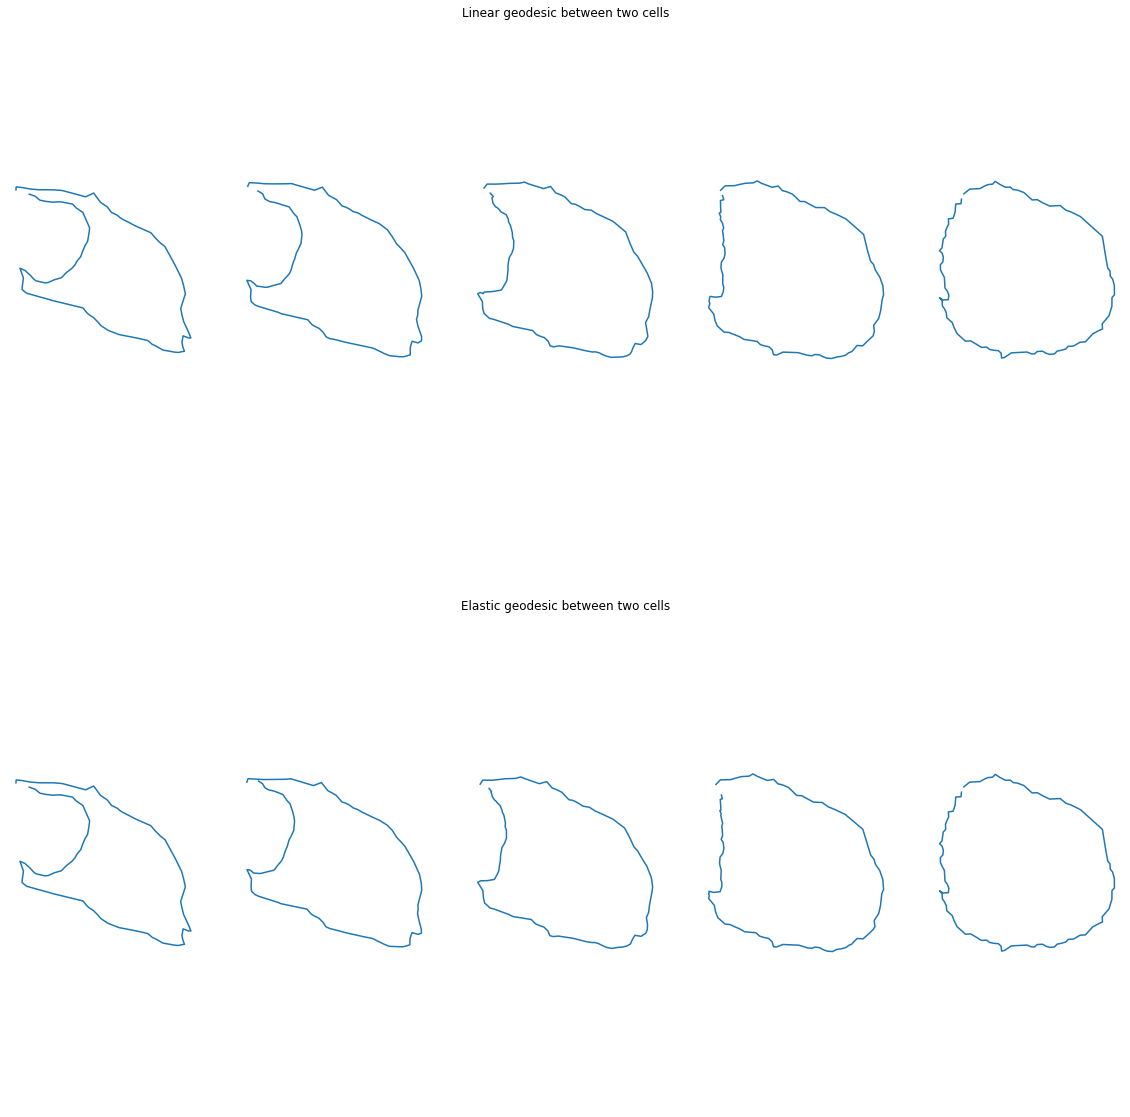

In [81]:
def linear_geodesic(initial_curve, end_curve, t):
    """Compute the curve at time t in the linear geodesic
    between initial_curve and end_curve.
    
    Returns
    -------
    curve : discrete curve
    """
    curve = (1 - t)*initial_curve + t*end_curve
    return curve

i, j = gs.random.randint(len(cells_shape), size=2)

points_linear = [linear_geodesic(cells_shape[i], cells_shape[j], t) for t in gs.linspace(0., 1., 5)]

fig = plt.figure(figsize = (20, 10))
plt.title("Linear geodesic between two cells")
plt.axis('off')

for k, curve in enumerate(points_linear):
    fig.add_subplot(2, 5, k + 1)
    plt.plot(curve[:, 0], curve[:, 1])
    plt.axis('equal')
    plt.axis('off')
    
geodesic = metric.geodesic(initial_curve=cells_shape[i], end_curve=cells_shape[j])
points_elastic = geodesic(gs.linspace(0., 1., 5))
    
for i, curve in enumerate(points_elastic):
    fig.add_subplot(2, 5, i + 6)
    plt.plot(curve[:, 0], curve[:, 1])
    plt.axis('equal')
    plt.axis('off')
    if i == 2:
        plt.title("Elastic geodesic between two cells")

We can see that the two geodesics are not that different from each other. Sometimes, we can spot geometric aberration for the linear geodesic (intersections). However, the advantage that they have is that the curves remain closed along the geodesic.

## 3.2 Classification of cell lines

In 2016, Lyons and al. used a neural network to classify cells from the same dataset (LAM2016). In their study, each cell was represented as a vector of geometric features.

Our dataset is a subset of theirs, and all the cells we are studying were observed with the GDA substrate. Thus, we can compare the accuracies of the two methods, and compare these accuracies with the ones we obtained with treated cells.

Neural network with geometric features: 0.69<br>
SVM with MDS on elastic curves: 0.63<br>
SVM with MDS on elastic curves (cytd treatment) : 0.72<br>
SVM with MDS on elastic curves (jasp treatment) : 0.87

**Reference**

(LAM2016) Lyons SM, Alizadeh E, Mannheimer J, et al. Changes in cell shape are correlated with metastatic potential in murine and human osteosarcomas. Biol Open. 2016;5(3):289-299. Published 2016 Feb 12. doi:10.1242/bio.013409

# 4. Limitations and perspectives

### Limitations of this analysis

While our analysis focuses on the shape of the cell external membrane, other features can be taken into account and used in practice to analyze cell shapes, including the shape of the nucleus, actin structure (affecting the image texture), other geometric measures such as circularity or aspect ratio (MGCKCKDDRTWSBCC2018, AXCFP2019). Interestingly, our single metric is able to produce good predictions in some cases, suggesting that the cell boundary shape also captures intra-cellular processes.

The data preprocessing that was done can also be optimized and improved, although it was performing well enough in our dataset. To compensate for the lack of features on discrete curves, we used functions from Geomstats that were originally designed for sets of landmarks in Kendall's shape space, and not the space of discrete elatic curves, which uses a different metric. Doing an exhaustive search to re-parametrize with the best starting point can also reveal to be unpractical as the dataset size, or the number of sampling points in each curve increase.

While being physically sound, the use of the elastic metric to visualize cell deformation may also not exactly reflect the dynamical changes that cells undergo. It would be interesting to study videos, instead of static images, to compare our numerical geodesics and the observed morphological trajectories and get a better understanding of the shape spaces where cells live in.

**References**

(MGCKCKDDRTWSBCC2018) McQuin C, Goodman A, Chernyshev V, Kamentsky L, Cimini BA, Karhohs KW, Doan M, Ding L, Rafelski SM, Thirstrup D, Wiegraebe W, Singh S, Becker T, Caicedo JC, Carpenter AE (2018). CellProfiler 3.0: Next-generation image processing for biology. PLoS Biol. 16(7):e2005970 / doi. PMID: 29969450

(AXCFP2019) Alizadeh E, Xu W, Castle J, Foss J, Prasad A. TISMorph: A tool to quantify texture, irregularity and spreading of single cells. PloS one. 2019 Jun 3;14(6):e0217346.

### Limitations of Geomstats

The first limitation that we faced is that Geomstats current implementation only deals with open curves. This restriction to open curves was not very clear when we first looked at the documentation. In the context of our application, having an implementation with closed curves would be quite relevant as cell boundaries are naturally closed. In this analysis, the cell boundaries were thus studied as open curves, which tends to produce some unrealistic distance between the two extreme points of the curves along a geodesic, which are considered to be open curves in the current framework of the package. 

To compare curves, we also had to preprocess the data, to take into account the fact that Geomstats does not consider that cells are defined up to transformations (such as rotations). As an example, we did the following experiement, to plot the geodesic trajectory between two simple shapes (squares and circles): While the starting points should not be relevant when analyzing closed curves and producing grodesic trajectories, having two unaligned starting points can produce undesired deformations that would move the curves to align them.

In [82]:
def unit_square(nb_points_side):
    """Generate a discrete curve representing a square 
    with nb_points_side sampling points by side.
    
    Returns
    -------
    square : discrete curve
    """
    nb_points = 2*(nb_points_side) + 2*(nb_points_side - 2)
    square = gs.zeros((nb_points, 2))
    
    pos_axis = gs.linspace(-1, 1, nb_points_side)
    neg_axis = gs.flip(pos_axis)
    ones = gs.ones(nb_points_side)
    minus_ones = -ones
    
    right = gs.vstack((pos_axis, minus_ones)).T
    top = gs.vstack((ones, pos_axis)).T
    left = gs.vstack((neg_axis, ones)).T
    bottom = gs.vstack((minus_ones, neg_axis)).T[:nb_points_side - 1]
    
    square[:nb_points_side] = right
    square[nb_points_side - 1 : 2*nb_points_side - 1] = top
    square[2*nb_points_side - 2 : 3*nb_points_side - 2] = left
    square[3*nb_points_side - 3 : 4*nb_points_side - 4] = bottom
    return square

def unit_circle(nb_points):
    """Generate a discrete curve with nb_points sampling points 
    representing the unit circle.
    
    Returns
    -------
    circle : discrete curve
    """
    t = gs.linspace(0, 2*gs.pi, nb_points + 1)[: -1]
    x = gs.cos(t)
    y = gs.sin(t)
    circle = gs.vstack((x, y)).T
    return circle

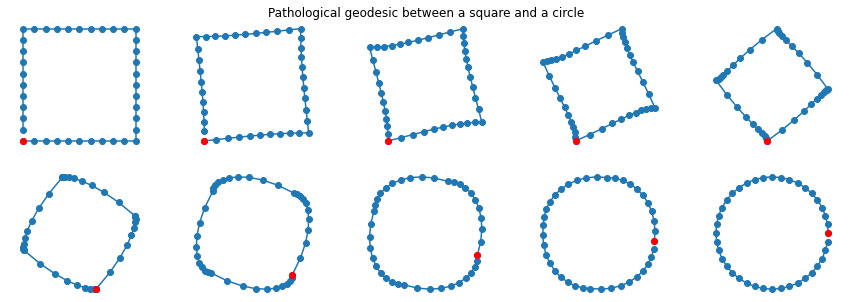

In [83]:
curves = DiscreteCurves(R2)
metric = curves.square_root_velocity_metric

square = unit_square(11)
circle = unit_circle(40)

geodesic = metric.geodesic(initial_curve=square, end_curve=circle)

points = geodesic(gs.linspace(0., 1., 10))

fig = plt.figure(figsize = (15, 5))
plt.title("Pathological geodesic between a square and a circle")
plt.axis('off')

for i in range(len(points)):
    fig.add_subplot(2, len(points)/2, i + 1)
    curve = points[i]
    plt.plot(curve[:, 0], curve[:, 1], '-o')
    plt.plot(curve[0, 0], curve[0, 1], 'ro')
    plt.axis('equal')
    plt.axis('off')

For this analysis, we also tried to project the dataset in 2D using a PCA on the tangent space at the Frechet mean, as done in another Geomstats notebook. However, this did not work because an exception was raised, due to the implementation missing for this manifold.

Finally, with the presence of high variability in shape in our data, we planned to do more statistical analysis and compare empirical variances between classes, e.g. doing an equivalent of Barlett's test . However, we did not succeed at computing the Frechet means (necessary to compute variances), as the current implementation of Geomstats does not allow it for discrete curves (error message mentioned some part of the implementation missing). We tried to fix it by implementing a new inner_product method in the SRVMetric class in the local repository and opened an issue (https://github.com/geomstats/geomstats/issues/995). With a better understanding of the current implementation, we could possibly contribute to improving this aspect of the package.<br>

### Proposed features of Geomstats

There are references (e.g. BBMM2014) that propose methods to study shapes of (open or closed) curves as quotient spaces, invariant by translation, scaling, rotation and reparametrization. As some use the square root velocity representation that is already implemented in Geomstats, the current framework of Geomstats could in principle be extended to deal with such spaces and to add closed curves.

In this study, we specifically considered the elastic metric, whose physical interpretation is quite relevant to the study of physical objects like cells. Furthermore, this metric belongs to a larger family of metrics defined by two parameters that quantify the cost of bending and stretching (MSJ2007). It would thus be interesting to estimate the bending and stretching parameters that match an experimental observed trajectory of cell shape, to study the biomechanical forces associated with it. While the elastic metric that is currently implemented in the square root velocity framework only corresponds to a specific couple of parameters, generalizing the implementation with a choice for these parameters would be useful to study morphological trajectories. Such an implementation can be naturally done by using a generalization of the square root velocity vector (BBMM2014).

**References**

(BBMM2014) Bauer M, Bruveris M, Marsland S, Michor PW. Constructing reparameterization invariant metrics on spaces of plane curves. Differential Geometry and its Applications. 2014 Jun 1;34:139-65.

(MSJ2007) Mio W, Srivastava A, Joshi S. On shape of plane elastic curves. International Journal of Computer Vision. 2007 Jul 1;73(3):307-24.